# Harry Potter and the Descriptive Analysis
Dataframe `hp` is loaded from the preprocessing notebook. Please look in that for the columns

In [1]:
# import statements
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

hp = pd.read_pickle('hp.gz')

### Word Count
Perhaps the simplest descriptive analysis is a word count

In [2]:
word_count = hp.groupby(['book_number', 'book_title'])['alpha'].sum()
word_count.name = 'word count'
print(word_count)

book_number  book_title                               
1            Harry Potter and the Sorcerer's Stone         77161.0
2            Harry Potter and the Chamber of Secrets       84783.0
3            Harry Potter and the Prisoner of Azkaban     106855.0
4            Harry Potter and the Goblet of Fire          189889.0
5            Harry Potter and the Order of the Phoenix    255530.0
6            Harry Potter and the Half-Blood Prince       168465.0
7            Harry Potter and the Deathly Hallows         196978.0
Name: word count, dtype: float64


<IPython.core.display.Javascript object>


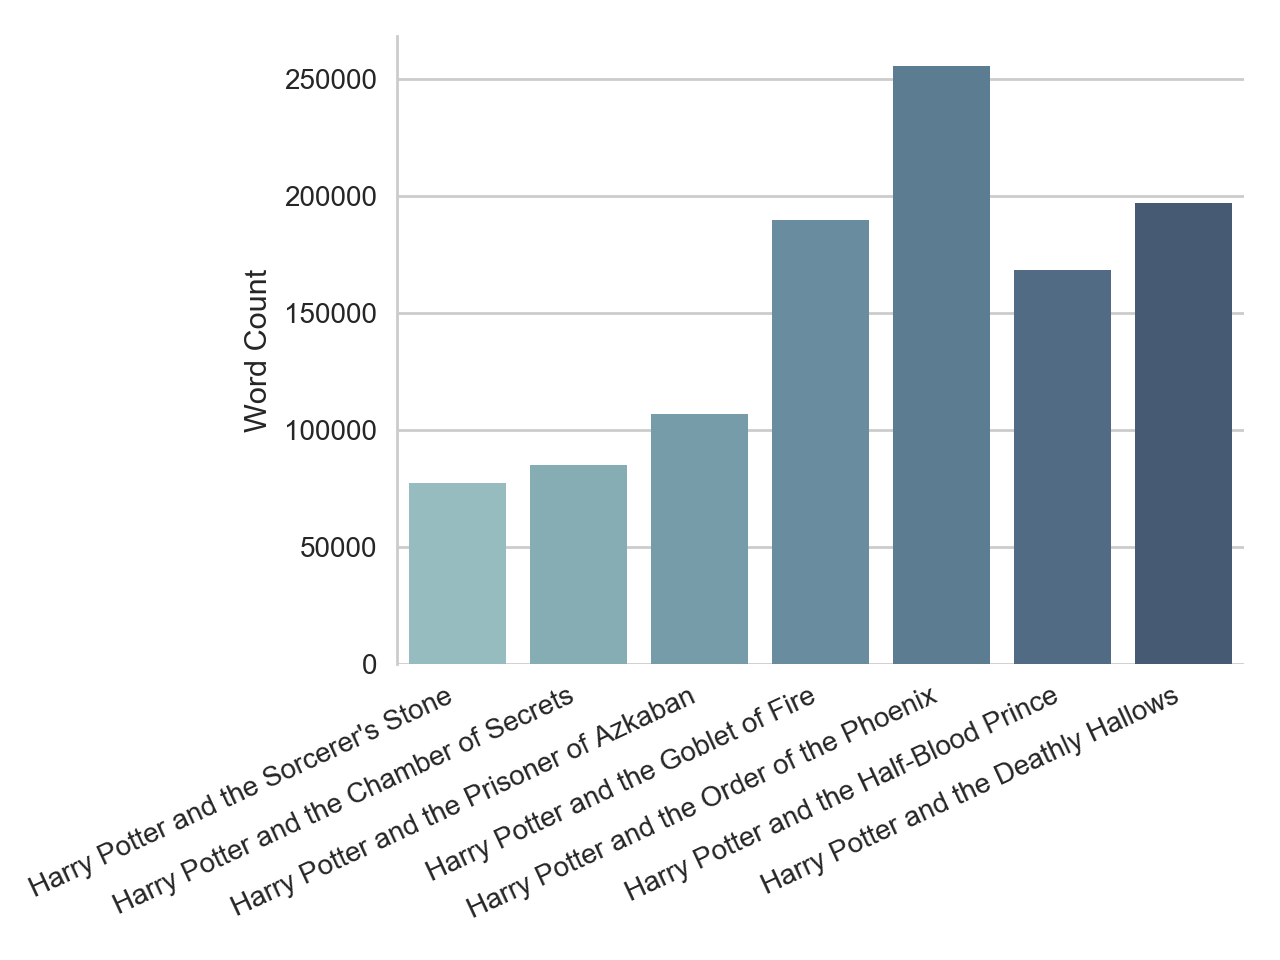

In [3]:
sns.set(style="whitegrid", context="notebook")

# initialize plot
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)

sns.barplot(word_count.index.get_level_values(1).values, word_count, palette=pal)

# Finalize the plot
labels = plt.gca().get_xticklabels()
plt.setp(labels, rotation=25, ha='right')
plt.ylabel('Word Count')
sns.despine(bottom=True)
plt.tight_layout(h_pad=3)

So Order of Phoenix is more than three times longer than Sorcerer's Stone

### Stop Words
Stop words are some of the most common words and contain little or no information about the text being analysed. Here I have used the stop word list from `nltk.corpus`, and look at the stop words in Harry Potter

In [4]:
stop_word_count = hp.lower[hp.stop].value_counts()
stop_word_count = stop_word_count[stop_word_count > 0]
stop_word_count.name = 'stop word count'

print("There are {} stop words in the Harry Potter novels corresponding to {:.0%} of all words".format(hp.stop.sum(), hp.stop.sum()/hp.alpha.sum()))

There are 513851 stop words in the Harry Potter novels corresponding to 48% of all words


In [5]:
stop_word_count.head() # most common stop words

the    51911
and    27597
to     26857
he     22187
of     21837
Name: stop word count, dtype: int64

<IPython.core.display.Javascript object>


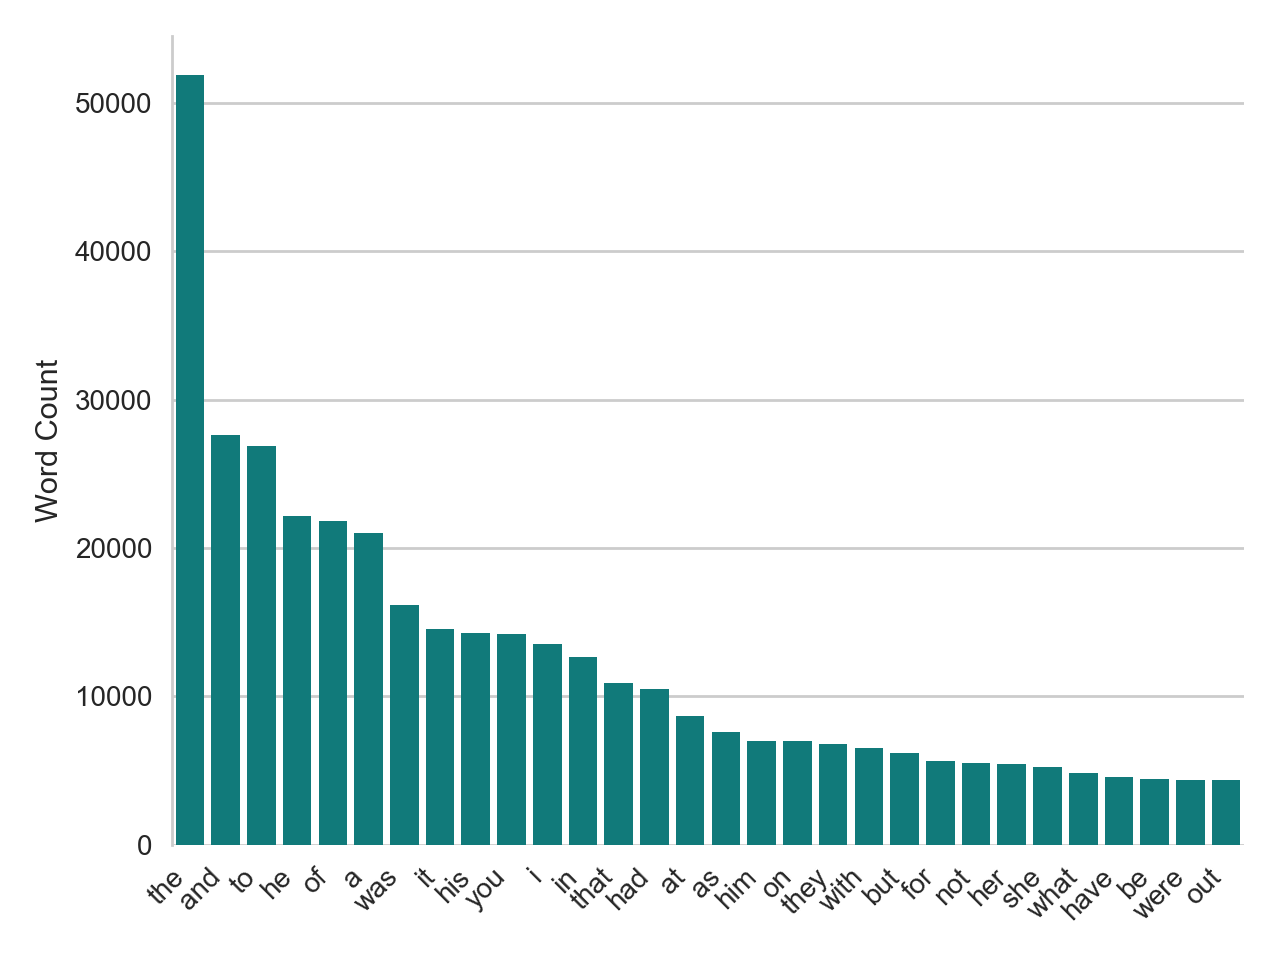

In [6]:
sns.set(style="whitegrid", context="notebook")

# initialize plot
sns.barplot(stop_word_count.index.get_level_values(0).astype(str).values[:30], stop_word_count[:30].values, color='DarkCyan')

# Finalize the plot
labels = plt.gca().get_xticklabels()
plt.setp(labels, rotation=45, ha='right')
plt.ylabel('Word Count')
sns.despine(bottom=True)
plt.tight_layout(h_pad=3)

### Vocabulary
The vocabulary is simply the number of unique words in a work.
Here I look at the vocabulary in the different books

In [7]:
vocabulary = hp[hp.alpha].groupby(['book_number', 'book_title'])['lower'].nunique()
vocabulary.name = 'vocabulary'

vocabulary_df = pd.DataFrame(vocabulary)
vocabulary_df['word count'] = word_count
vocabulary_df['percentage'] = vocabulary_df['vocabulary']/vocabulary_df['word count']
vocabulary_df

,,vocabulary,word count,percentage
book_number,book_title,,,
1,Harry Potter and the Sorcerer's Stone,5604,77161.0,0.072627
2,Harry Potter and the Chamber of Secrets,6689,84783.0,0.078896
3,Harry Potter and the Prisoner of Azkaban,7228,106855.0,0.067643
4,Harry Potter and the Goblet of Fire,9890,189889.0,0.052083
5,Harry Potter and the Order of the Phoenix,11734,255530.0,0.045920
6,Harry Potter and the Half-Blood Prince,9961,168465.0,0.059128
7,Harry Potter and the Deathly Hallows,10708,196978.0,0.054361


While it looks like the vocabulary is correlated with the length of the book the relative number of unique words decrease with book length.

This seems reasonable considering, that there are a lot of common words that will be in use nomatter the length of the text.

The points can be plotted against each other

<IPython.core.display.Javascript object>


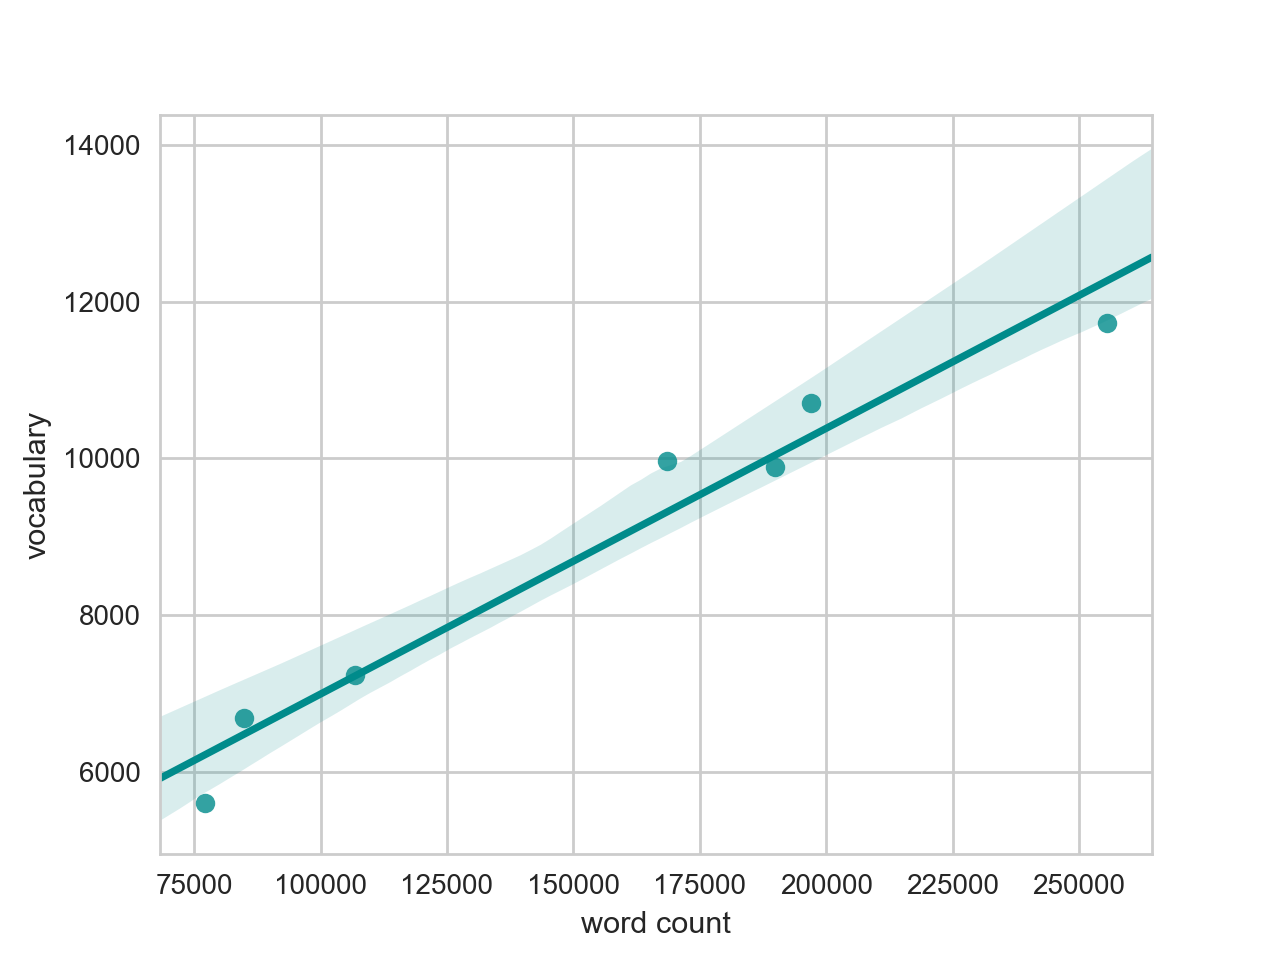

In [8]:
sns.regplot(x='word count', y='vocabulary', data=vocabulary_df, color='DarkCyan')

So it appears that the word count and vocabulary are correlated with a roughly linear relationship.

But we can do better than that by looking at individual chapters and the Harry Potter books as a whole

<IPython.core.display.Javascript object>


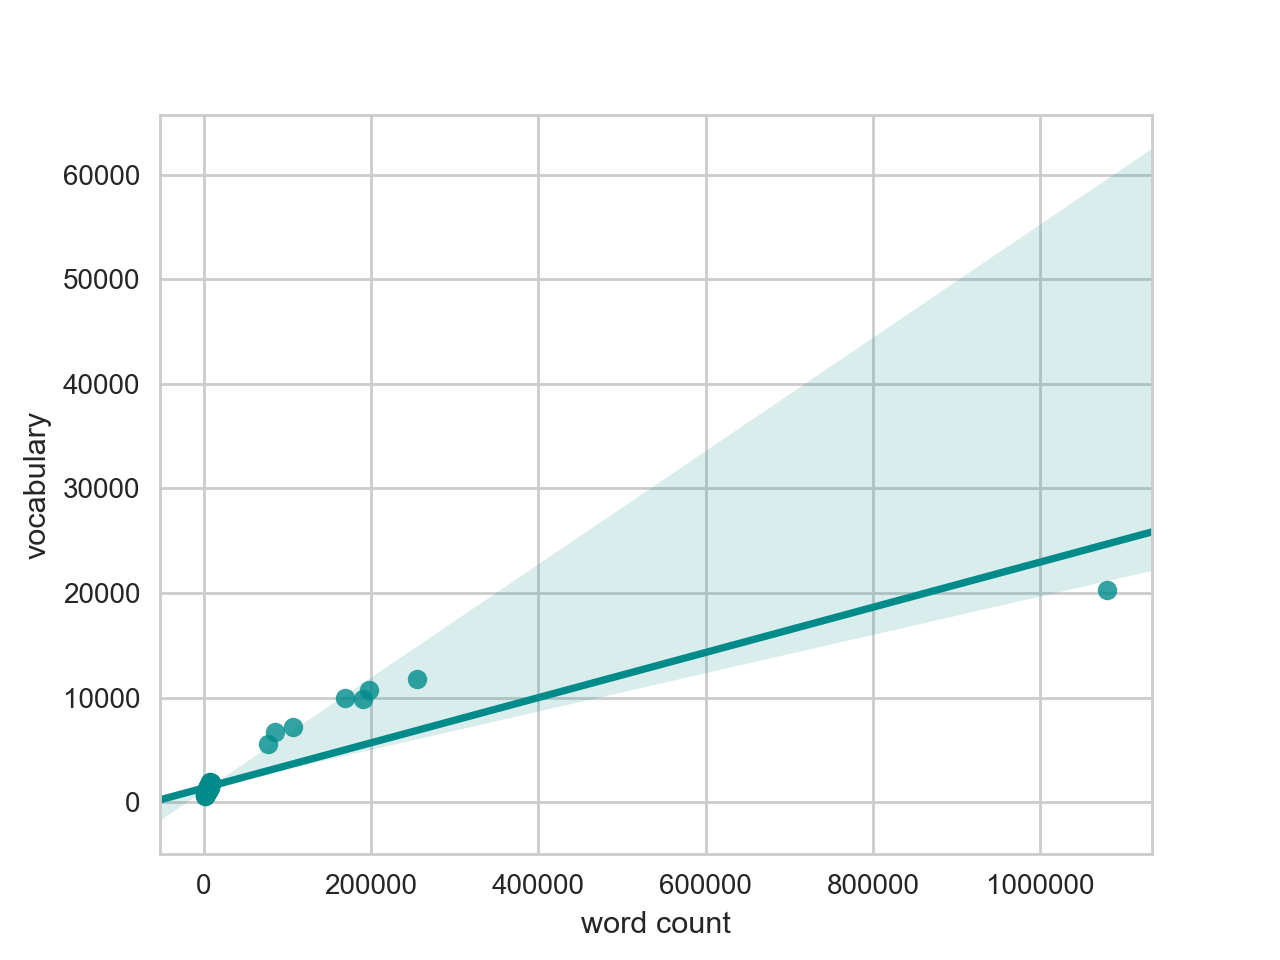

In [9]:
# word count by chapter
word_count2 = list(hp.groupby(['chapter_number', 'chapter_title'])['alpha'].sum())
word_count2 = word_count2 + list(word_count) + [hp.alpha.sum()] # concatenate with word count by book and total
word_count2 = pd.Series(word_count2)
word_count2.name = 'word count'

# vocabulary by chapter
vocabulary2 = list(hp[hp.alpha].groupby(['chapter_number', 'chapter_title'])['lower'].nunique())
vocabulary2 = vocabulary2 + list(vocabulary) + [hp[hp.alpha].lower.nunique()]
vocabulary2 = pd.Series(vocabulary2)
vocabulary2.name = 'vocabulary'

# concatenate 
vocabulary2_df = pd.DataFrame(vocabulary2)
vocabulary2_df['word count'] = word_count2

sns.regplot(x='word count', y='vocabulary', data=vocabulary2_df, color='DarkCyan')

Clearly a linear model does not work. Let's try to plot on logarithmic axes

<IPython.core.display.Javascript object>


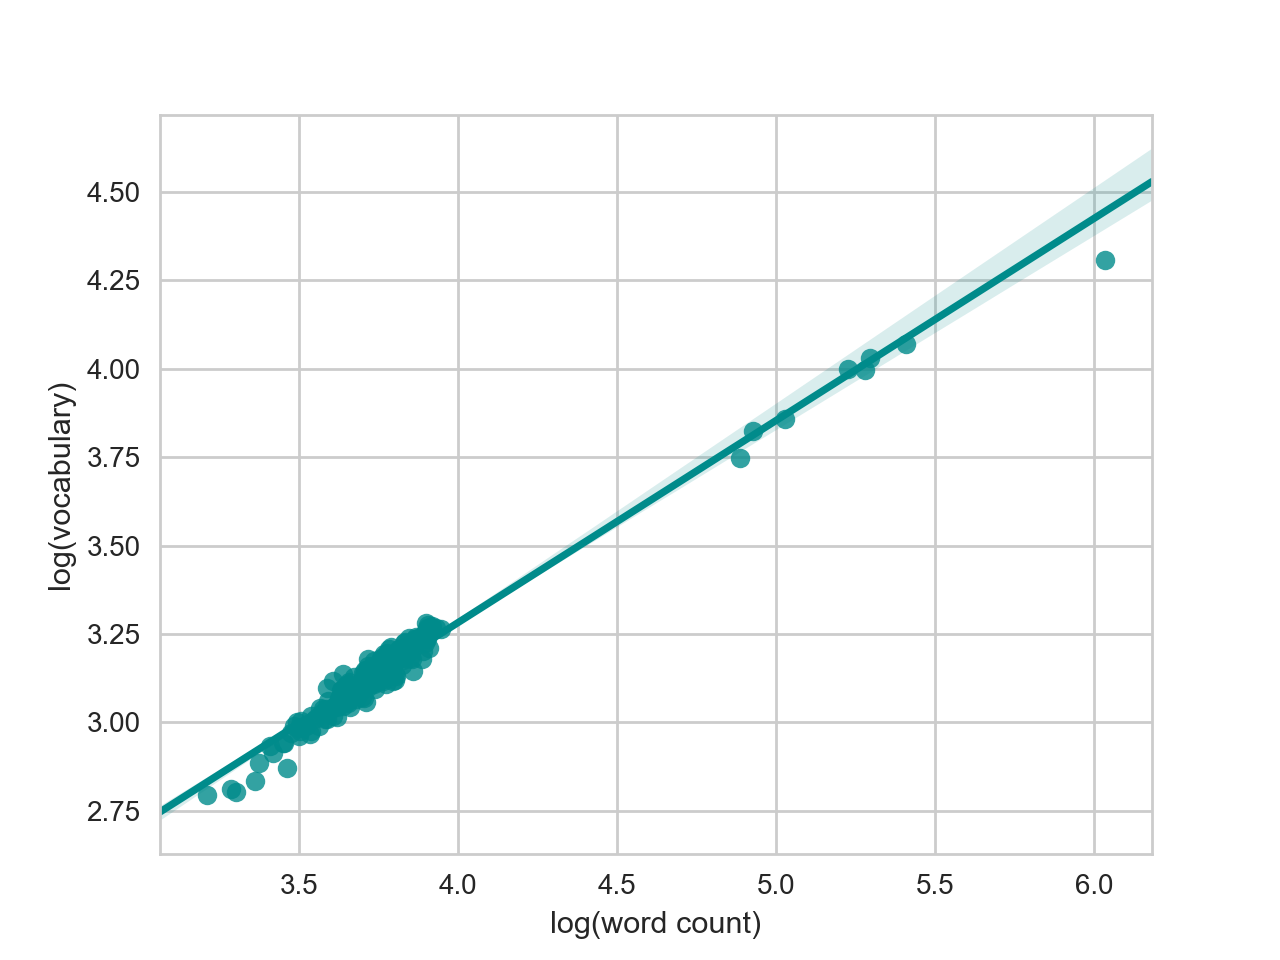

In [10]:
vocabulary2_df['log(word count)'] = np.log10(vocabulary2_df['word count'])
vocabulary2_df['log(vocabulary)'] = np.log10(vocabulary2_df['vocabulary'])

sns.regplot(x='log(word count)', y='log(vocabulary)', data=vocabulary2_df, color='DarkCyan')

which works incredibly well. The vocabulary seems to be a power-law function of word count

Let's see if some other texts from the Gutenberg corpus match the Harry Potter data

In [11]:
from nltk.corpus import gutenberg

n_word, n_vocab = [], []
fileids = gutenberg.fileids()
for fileid in fileids:
    words = [word.lower() for word in gutenberg.words(fileid) if word.isalpha()]
    n_word.append(len(words))
    n_vocab.append(len(set(words)))
gutenberg_df = pd.DataFrame({'word count':n_word, 'vocabulary':n_vocab})
gutenberg_df.index = fileids

gutenberg_df['log(word count)'] = np.log10(gutenberg_df['word count'])
gutenberg_df['log(vocabulary)'] = np.log10(gutenberg_df['vocabulary'])

gutenberg_df

,vocabulary,word count,log(word count),log(vocabulary)
austen-emma.txt,7079,161600,5.208441,3.849972
austen-persuasion.txt,5739,84121,4.924904,3.758836
austen-sense.txt,6283,120733,5.081826,3.798167
bible-kjv.txt,12568,791842,5.898639,4.099266
blake-poems.txt,1510,6934,3.840984,3.178977
bryant-stories.txt,3826,46611,4.668488,3.582745
burgess-busterbrown.txt,1521,16327,4.212906,3.182129
carroll-alice.txt,2569,27333,4.436687,3.409764
chesterton-ball.txt,8157,82682,4.917411,3.911530
chesterton-brown.txt,7737,73286,4.865021,3.888573


<IPython.core.display.Javascript object>


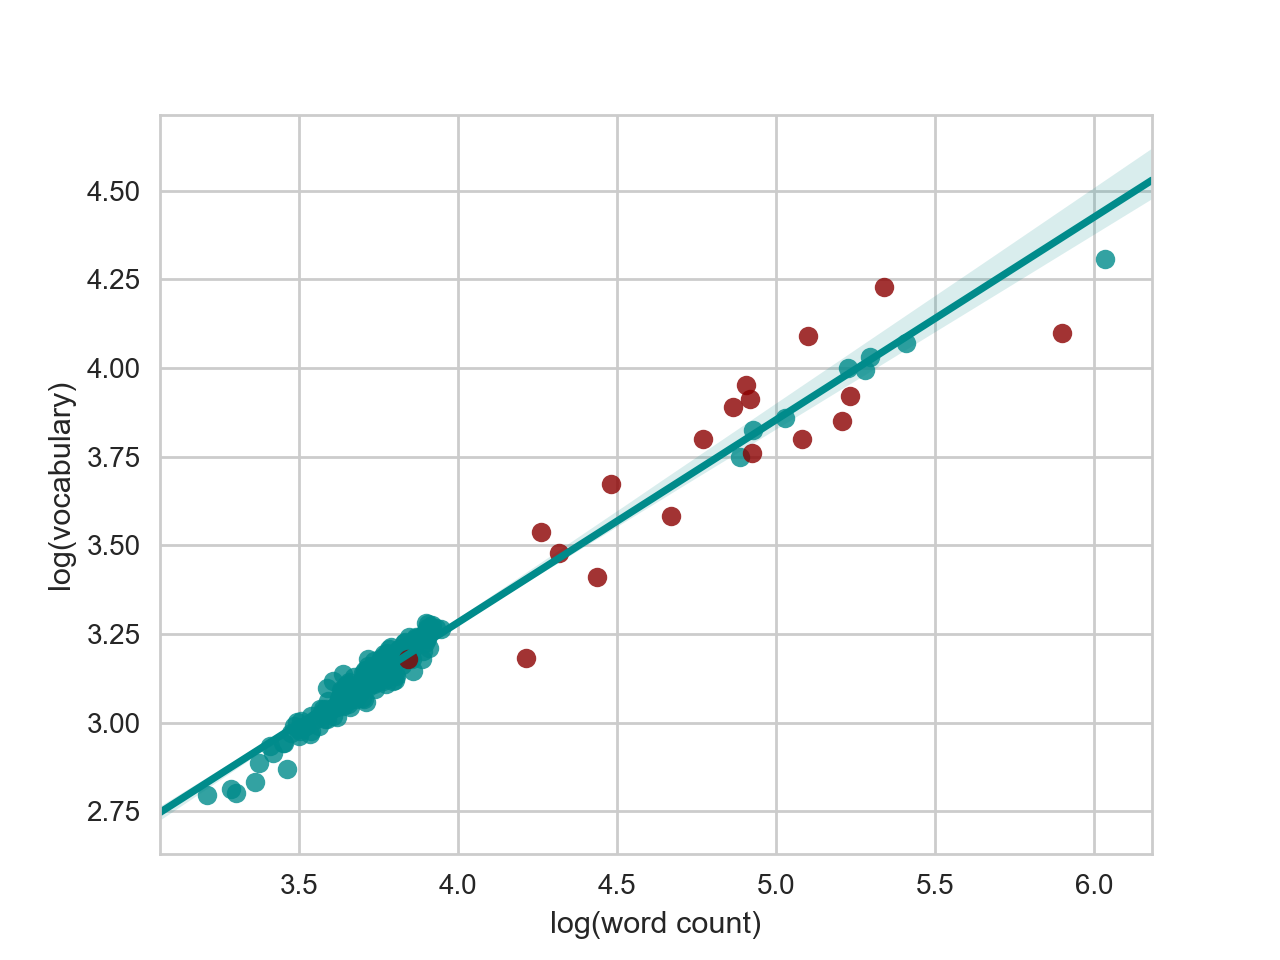

In [12]:
sns.regplot(x='log(word count)', y='log(vocabulary)', data=vocabulary2_df, color='DarkCyan')
sns.regplot(x='log(word count)', y='log(vocabulary)', data=gutenberg_df, color='DarkRed', fit_reg=False)

There is more scatter but overall the texts from the Gutenberg corpus seem to align well with the Harry Potter data.